# Initializing environment

In [19]:
import numpy as np
import os
from sklearn.pipeline import Pipeline

# To make the output stable across other runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_farmer_income_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Loading model and datasets

In [2]:
import pandas as pd

train_df = pd.read_excel('Pearl Challenge data with dictionary.xlsx', sheet_name='TrainData')
test_df = pd.read_excel('Pearl Challenge data with dictionary.xlsx', sheet_name='TestData')

In [24]:
from joblib import load
import lightgbm as lgb

lgb_best = load("best_lgbm_model.pkl")

preprocessor = lgb_best.named_steps['preprocessor']
lgb_best_model = lgb_best.named_steps['regressor']

# Preprocessing the datasets

In [43]:
from sklearn.model_selection import train_test_split

drop_cols = ['FarmerID', 'Zipcode', 'CITY', 'DISTRICT', 'VILLAGE', 'Location']
target = 'Target_Variable/Total Income'
X = train_df.drop(columns=[target] + drop_cols)
y = train_df[target]

X_test = test_df.drop(columns=[target] + drop_cols)

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

X[num_cols] = X[num_cols].fillna(X[num_cols].mean())

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = test_df.drop(columns=[target] + drop_cols)

# Feature Importance

In [27]:
importances = lgb_best_model.feature_importances_
feature_names = preprocessor.get_feature_names_out()

print(importances.shape)
print(feature_names.shape)

(7673,)
(7673,)


In [28]:
import pandas as pd

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)


C:\Temp\ipykernel_21080\1887971331.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features_df, x='importance', y='feature', palette='magma')


Saving figure Top 30 Feature Imporatnces


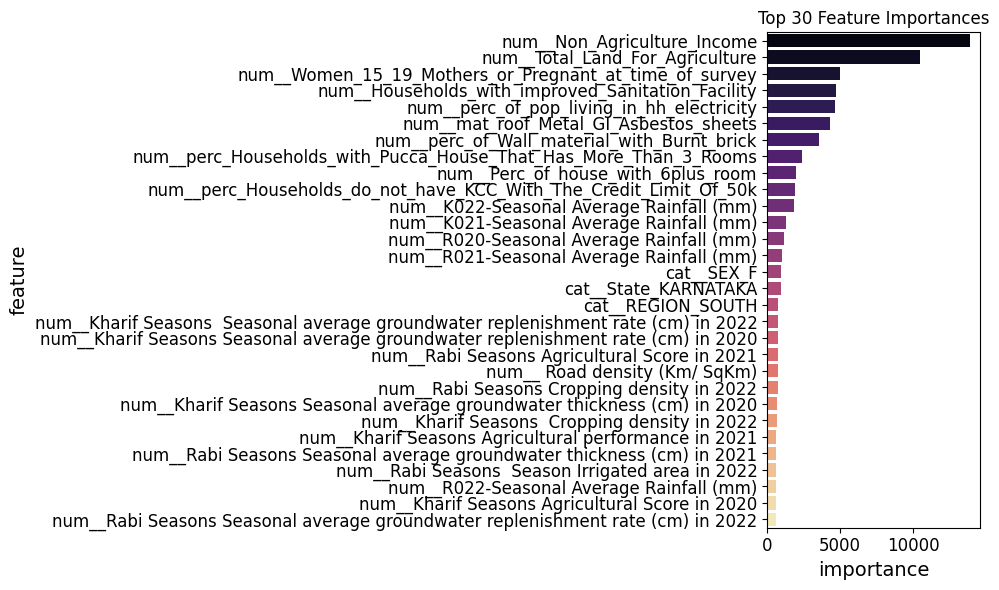

In [33]:
top_k = 30

top_features_df = feature_importance_df.sort_values(by='importance', ascending=False).head(top_k)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features_df, x='importance', y='feature', palette='magma')
plt.title(f"Top {top_k} Feature Importances")
plt.tight_layout()

save_fig("Top 30 Feature Imporatnces")
plt.show()


In [50]:
top5_idx = np.argsort(importances)[-5:][::-1]
top5_features = [num_cols[i] for i in top5_idx]

# Create a DataFrame for analysis
results_df = X_val[top5_features].copy()
results_df["Actual"] = y_val.values
results_df["Predicted"] = y_pred
results_df["APE"] = np.abs(results_df["Actual"] - results_df["Predicted"]) / np.maximum(results_df["Actual"], 1)


C:\Temp\ipykernel_21080\3898663629.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mape_by_bin = results_df.groupby("bin")["APE"].mean() * 100  # in %
C:\Temp\ipykernel_21080\3898663629.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mape_by_bin.index.astype(str), y=mape_by_bin.values, palette='viridis')
C:\Temp\ipykernel_21080\3898663629.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mape_by_bin = results_df.groupby("bin")["APE"].mean() * 100  

Saving figure MAPE by Feature Bin (Top 5 Features)


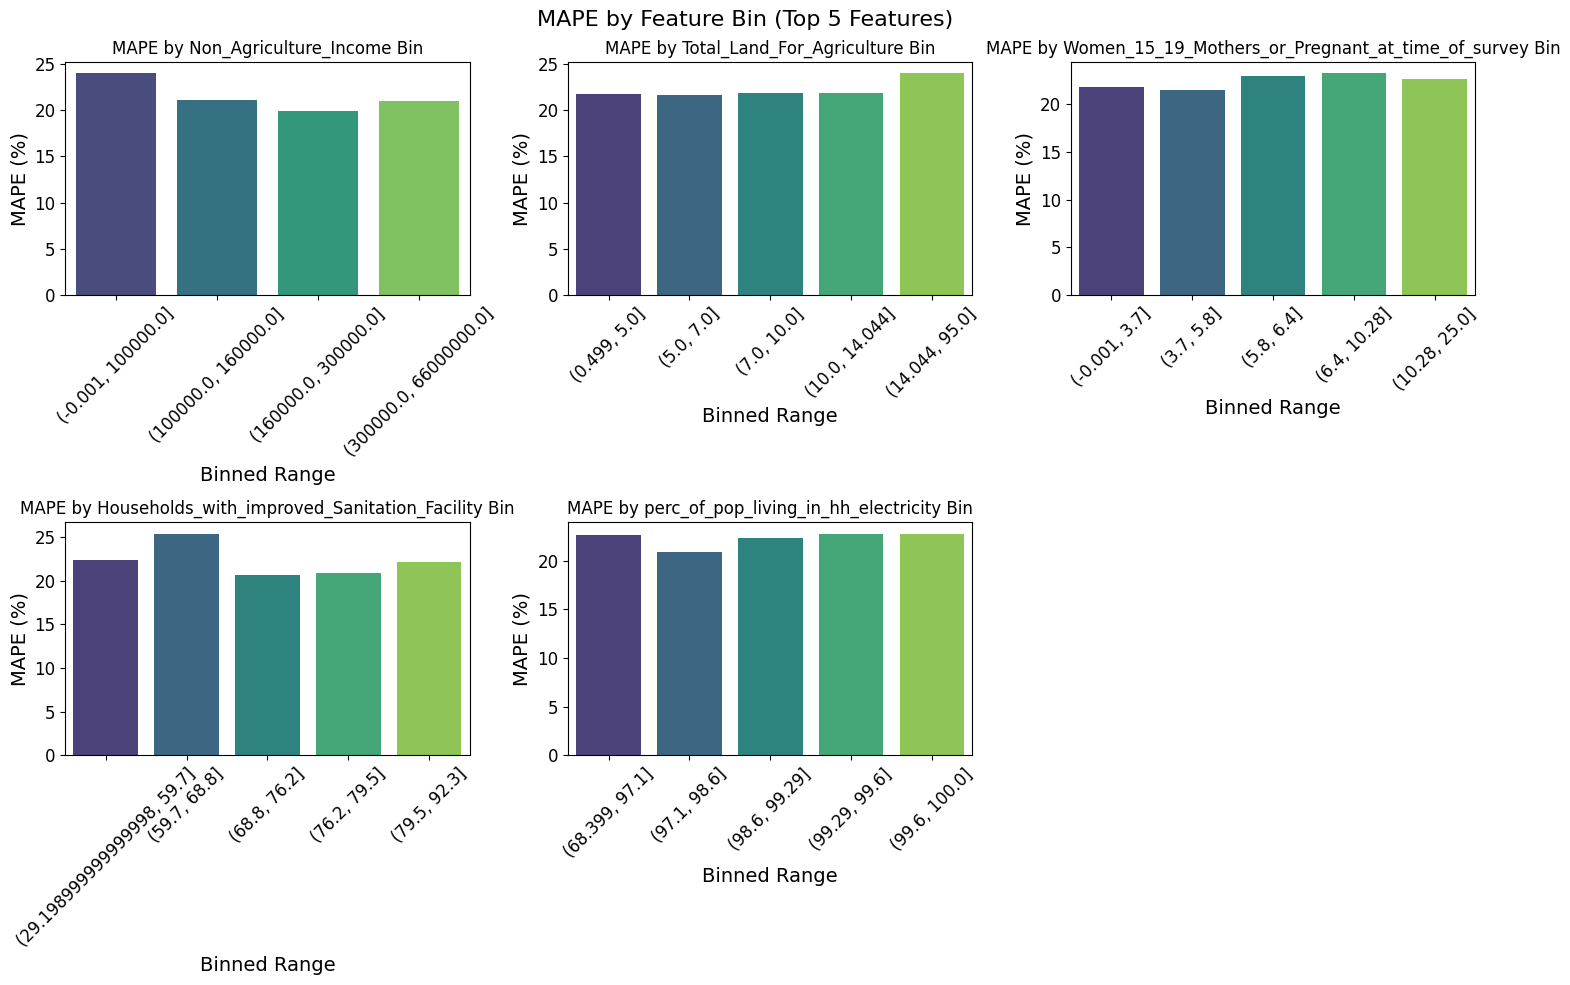

In [52]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top5_features):
    plt.subplot(2, 3, i+1)
    
    # Quantile binning into 5 bins
    results_df["bin"] = pd.qcut(results_df[feature], q=5, duplicates='drop')
    
    # Compute MAPE per bin
    mape_by_bin = results_df.groupby("bin")["APE"].mean() * 100  # in %
    
    # Plot
    sns.barplot(x=mape_by_bin.index.astype(str), y=mape_by_bin.values, palette='viridis')
    plt.title(f'MAPE by {feature} Bin')
    plt.xlabel('Binned Range')
    plt.ylabel('MAPE (%)')
    plt.xticks(rotation=45)

plt.suptitle("MAPE by Feature Bin (Top 5 Features)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

save_fig("MAPE by Feature Bin (Top 5 Features)")
plt.show()

# Validation Prediction accuracy

In [34]:
from sklearn.metrics import mean_absolute_percentage_error

y_pred = lgb_best.predict(X_val)

print(f"Validation MAPE: {mean_absolute_percentage_error(y_val, y_pred)*100} %")

C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Validation MAPE: 22.257999912394887 %


Saving figure Actual vs Predicted Farmer Income


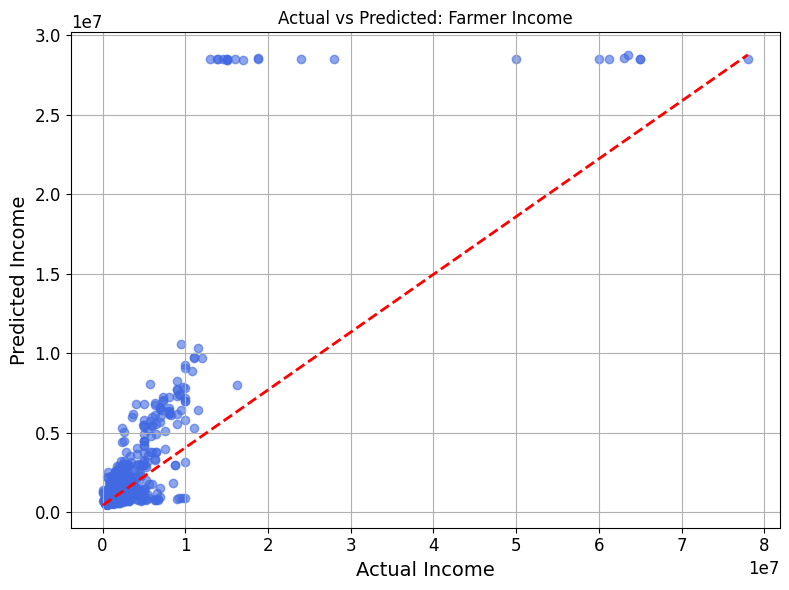

In [45]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.6, color='royalblue')
plt.plot([y_val.min(), y_val.max()], [y_pred.min(), y_pred.max()], 'r--', lw=2)  # Ideal line
plt.xlabel('Actual Income')
plt.ylabel('Predicted Income')
plt.title('Actual vs Predicted: Farmer Income')
plt.grid(True)
plt.tight_layout()

save_fig("Actual vs Predicted Farmer Income")
plt.show()


Saving figure residual_plot


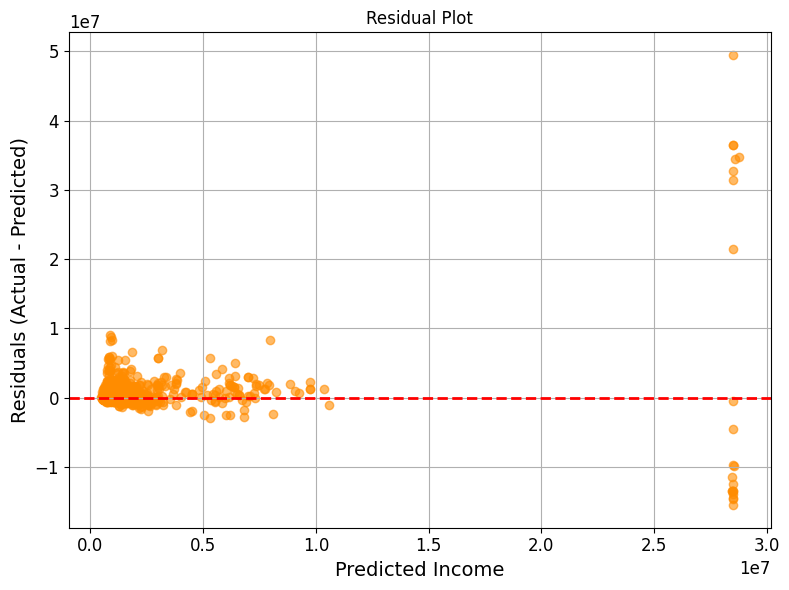

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate residuals
residuals = y_val - y_pred

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='darkorange')
plt.axhline(0, color='red', linestyle='--', linewidth=2)  # Zero residual line
plt.xlabel('Predicted Income')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.tight_layout()

save_fig("residual_plot")
plt.show()


Saving figure Error Distribution Histogram


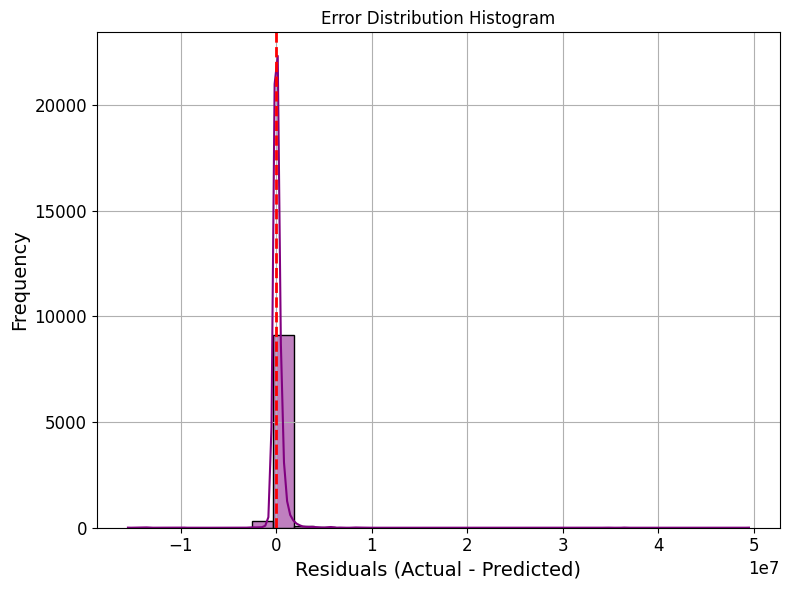

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_val - y_pred

# Plot histogram using seaborn for smoother curves
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.axvline(0, color='red', linestyle='--', linewidth=2)  # Mean error line
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Error Distribution Histogram')
plt.grid(True)
plt.tight_layout()

save_fig("Error Distribution Histogram")
plt.show()


# Learning Curve

Saving figure Learning Curve lgbm


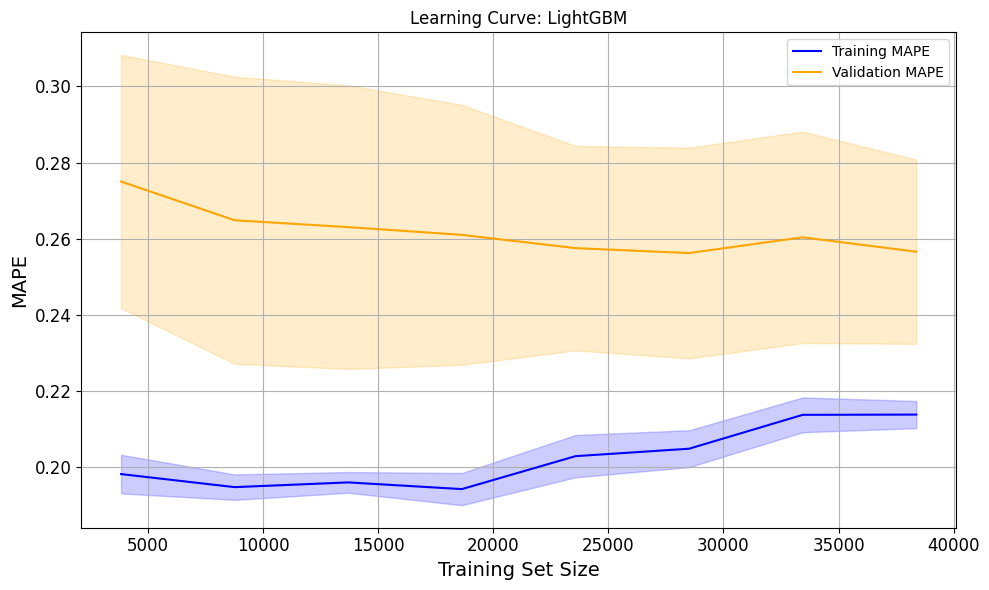

In [56]:
from sklearn.model_selection import learning_curve

# Get learning curve metrics
train_sizes, train_scores, test_scores = learning_curve(
    estimator=lgb_best,
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1
)

# Convert negative MAPE to positive
train_scores = -train_scores
test_scores = -test_scores

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training MAPE', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

plt.plot(train_sizes, test_mean, label='Validation MAPE', color='orange')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='orange')

plt.xlabel("Training Set Size")
plt.ylabel("MAPE")
plt.title("Learning Curve: LightGBM")
plt.legend()
plt.grid(True)
plt.tight_layout()

save_fig("Learning Curve lgbm")
plt.show()

# Test Data Prediction

In [13]:
predictions = lgb_best.predict(X_test)

output_df = pd.DataFrame({
    'FarmerID': test_df['FarmerID'],
    'Target_Variable/Total Income': predictions
})

output_df['FarmerID'] = output_df['FarmerID'].astype(str)
output_df.to_excel("predicted_results_lgbm1.xlsx", index=False)

print(f"Predictions saved to 'predicted_results_lgbm1.xlsx'")

C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Predictions saved to 'predicted_results_lgbm1.xlsx'


# GeoPlot

In [69]:
import geopandas as gpd

india_states = gpd.read_file('India_State_Boundary.shp')

print(india_states.describe())

        State_Name                                           geometry
count           37                                                 37
unique          36                                                 37
top     Puducherry  MULTIPOLYGON (((10341718.474 1449533.160500001...
freq             2                                                  1


Saving figure geoplot


<Figure size 1200x1000 with 0 Axes>

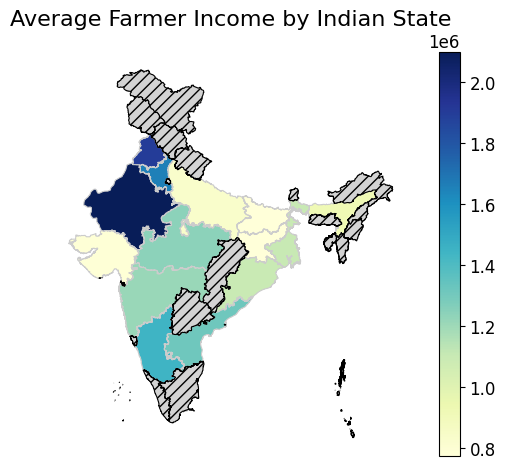

In [75]:
import geopandas as gpd
import matplotlib.pyplot as plt

state_income = train_df.groupby('State')['Target_Variable/Total Income'].mean().reset_index()
state_income.columns = ['State_Name', 'avg_income']
state_income['State_Name'] = state_income['State_Name'].str.lower()

india_states = gpd.read_file('India_State_Boundary.shp')
india_states['State_Name'] = india_states['State_Name'].str.lower()

merged = india_states.merge(state_income, on='State_Name', how='left')

# --- Plot Choropleth ---
plt.figure(figsize=(12, 10))
ax = merged.plot(column='avg_income', cmap='YlGnBu', linewidth=0.8, edgecolor='0.8', legend=True,
                missing_kwds={
                "color": "lightgrey",   
                "edgecolor": "black",
                "hatch": "///",           
                "label": "No Data"} )

ax.set_title('Average Farmer Income by Indian State', fontdict={'fontsize': 16})
ax.axis('off')

plt.tight_layout()

save_fig("geoplot")
plt.show()
